In [76]:
%matplotlib inline

In [77]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import tqdm

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


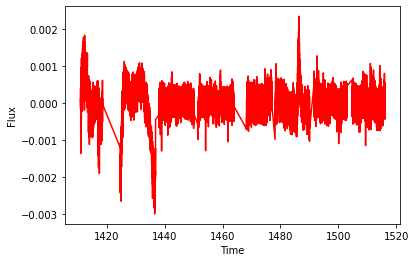

In [78]:
### TESS data import ###
data = np.loadtxt("tessbpic.dat",usecols=(0,1))
time = data[:,0]
# à prendre vers 1440
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1]
#flux = np.reshape(flux,[32,int(62976/32)])

flux_error = 1e-6*np.ones_like(time)
fig = plt.figure()
ax = plt.gca()
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Flux")
fig.show()

In [87]:
time = data[:,0][34400:34600]
# à prendre vers 1440
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1][34400:34600]
flux_error = 1e-6*np.ones_like(time)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


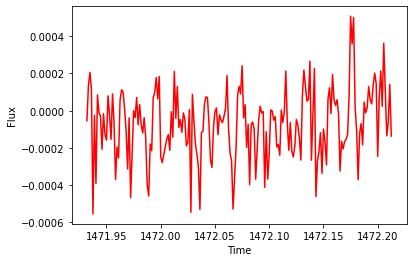

In [88]:
### Data plot ###
fig = plt.figure()
ax = plt.gca()
ax.plot(time,flux,c="r")
ax.set_xlabel("Time")
ax.set_ylabel("Flux")
fig.show()

In [89]:
### GP Model ###
bounds = dict(log_S0= (-10,10), log_Q = (-10,10), log_omega0 = (0,10))
kernel = terms.SHOTerm(log_S0=6.5, log_Q=2.5, log_omega0=5.,bounds=bounds)

gp = celerite.GP(kernel,fit_mean=True)
gp.compute(time)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -887.957228362793
parameter_dict:
OrderedDict([('kernel:log_S0', 6.5), ('kernel:log_Q', 2.5), ('kernel:log_omega0', 5.0), ('mean:value', 0.0)])



In [90]:
x = np.linspace(np.min(time),np.max(time),2000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

C:\ProgramData\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


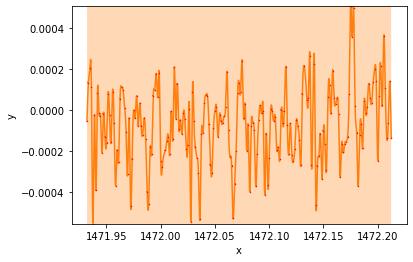

In [91]:
color = "#ff7f0e"
#plt.scatter(time,flux,c="r",s=1)
plt.errorbar(time,flux,yerr=flux_error,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.show()

In [92]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',bounds=bounds,args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: -1253.808404596055
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.00567229e+01,  5.47512354e+02, -8.50577158e+02,  1.65255187e-01])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 290
      nit: 2
   status: 2
  success: False
        x: array([-3.56771993e+00,  8.85109574e-01,  1.94917578e+00, -2.08719716e-07])
Final log-likelihood: 1253.808404596055
[0.02822012 2.4232499  7.02289678 0.99999979]
Parameters: OrderedDict([('kernel:log_S0', -3.5677199286796903), ('kernel:log_Q', 0.8851095741060477), ('kernel:log_omega0', 1.9491757791880377), ('mean:value', -1.9871971667815e-07)])


In [93]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)
P = 2*np.pi/(results.x[2]*60*24)
P

0.002238547788544529

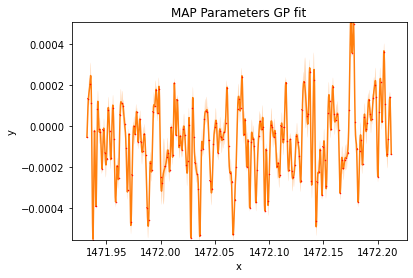

In [94]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.errorbar(time,flux,yerr=flux_error,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(np.min(flux),np.max(flux))
plt.title("MAP Parameters GP fit")
plt.show()
# plt.scatter(x,flux - pred_mean,c='k',s=1)
# plt.axhline(y=0,color='k')
# plt.title("Residuals")
# plt.show()

In [95]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else np.inf

In [96]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-10 < params[0] < 10) and (-10 < params[1] < 10) and (0 < params[2] < 10) and (-10 < params[3] < 10)) :
        return 0
    return -np.inf

In [97]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else np.inf

In [98]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000)
print("Finished")

Running burn-in...
Running production...
Finished


In [99]:
print("Final MCMC Parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC Parameters: OrderedDict([('kernel:log_S0', -4.247628601479541), ('kernel:log_Q', -7.1376581445005645), ('kernel:log_omega0', 3.7332892016139962), ('mean:value', 0.014674133972921978)])
Final MCMC log likelihood: 1404.4441901494267


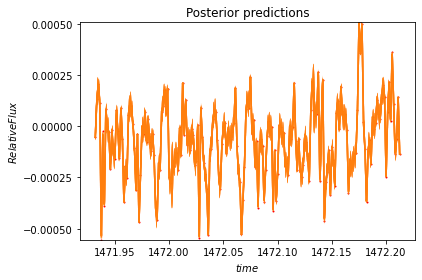

In [100]:
# Plot the data.
plt.scatter(time,flux,c="r",s=1)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu,pred_varvar = gp.predict(flux, x, return_var=True)
    pred_std = np.sqrt(pred_var)
    plt.plot(x, mu, color=color, alpha=0.3)
    plt.fill_between(x, mu+pred_std, mu-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
    
plt.ylabel(r"$Relative Flux$")
plt.xlabel(r"$time$")
plt.ylim(np.min(flux),np.max(flux))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("Posterior predictions");